In [1]:
import gym
import gym_2048
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import random
import warnings

from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

warnings.filterwarnings(action='ignore')

In [2]:
env = gym.make('2048-v0')
obs = env.reset()

print(obs)
print(env.observation_space)
print(env.action_space)

obs, _, _, _ = env.step(0)
print(obs)

[[0 0 0 2]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 4 0]]
Box([[2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]], [[4294967296 4294967296 4294967296 4294967296]
 [4294967296 4294967296 4294967296 4294967296]
 [4294967296 4294967296 4294967296 4294967296]
 [4294967296 4294967296 4294967296 4294967296]], (4, 4), int64)
Discrete(4)
[[2 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [4 0 2 0]]


랜덤 행동 에이전트

In [3]:
score = 0
step = 0
obs = env.reset()

while True:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    
    score += reward
    step += 1
    if done:
        break
        
print('score:', score, 'step:', step)
print(obs)

score: 1412 step: 152
[[ 16   4  16   2]
 [  4  32  64  16]
 [ 16 128   4   2]
 [  2   4  16   4]]


2048 게임 원-핫 인코딩

In [4]:
layer_count = 12
table = {2**i:i for i in range(layer_count)}
print(table)

def preprocess(obs):
    x = np.zeros((4, 4, layer_count))
    for i in range(4):
        for j in range(4):
            if obs[i, j] > 0:
                v = min(obs[i, j], 2**(layer_count-1))
                x[i, j, table[v]] = 1
            else:
                x[i, j, 0] = 1
    return x

{1: 0, 2: 1, 4: 2, 8: 3, 16: 4, 32: 5, 64: 6, 128: 7, 256: 8, 512: 9, 1024: 10, 2048: 11}


모델 정의 함수

In [5]:
layer_count = 12

def build_model():
    dense1, dense2 = 128, 128
    x = tf.keras.Input(shape=(4,4,layer_count))
    
    conv_a = tf.keras.layers.Conv2D(dense1, kernel_size=(2,1), activation='relu')(x)
    conv_b = tf.keras.layers.Conv2D(dense1, kernel_size=(1,2), activation='relu')(x)
    
    conv_aa = tf.keras.layers.Conv2D(dense1, kernel_size=(2,1), activation='relu')(conv_a)
    conv_ab = tf.keras.layers.Conv2D(dense1, kernel_size=(1,2), activation='relu')(conv_a)
    conv_ba = tf.keras.layers.Conv2D(dense1, kernel_size=(2,1), activation='relu')(conv_b)
    conv_bb = tf.keras.layers.Conv2D(dense1, kernel_size=(1,2), activation='relu')(conv_b)
    
    flat = [tf.keras.layers.Flatten()(a) for a in [conv_a, conv_b, conv_aa, conv_ab, conv_ba, conv_bb]]
    
    concat = tf.keras.layers.Concatenate()(flat)
    dense1 = tf.keras.layers.Dense(256, activation='relu')(concat)
    out = tf.keras.layers.Dense(4, activation='linear')(dense1)
    
    model = tf.keras.Model(inputs = x, outputs = out)
    model.compile(optimizer=tf.optimizers.RMSprop(learning_rate=0.0005), loss='mse')
    return model

model = build_model()
target_model = build_model()

학습 함수 정의

In [6]:
gamma = 0.9
batch_size = 512
max_memory = batch_size*8
memory = []

def append_sample(state, action, reward, next_state, done):
    memory.append([state, action, reward, next_state, done])

def train_model():
    np.random.shuffle(memory)

    len = max_memory // batch_size
    for k in range(len):
        mini_batch = memory[k*batch_size:(k+1)*batch_size]

        states = np.zeros((batch_size, 4, 4, layer_count))
        next_states = np.zeros((batch_size, 4, 4, layer_count))
        actions, rewards, dones = [], [], []

        for i in range(batch_size):
            states[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3]
            dones.append(mini_batch[i][4])

        target = model.predict(states)
        next_target = target_model.predict(next_states)

        for i in range(batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + gamma * np.amax(next_target[i])

        model.fit(states, target, batch_size=batch_size, epochs=1, verbose=0)

DQN 학습

In [7]:
import math

def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits))
    sum_exp_logits = np.sum(exp_logits)
    return exp_logits / sum_exp_logits

max_episodes = 10001
epsilon = 0.9
epsilon_min = 0.1

scores = []
steps = []
iteration = 0

train_count = 0


for i in tqdm(range(max_episodes)):
    if i % 100 == 0 and i != 0:
        print('episode :', i, 'score mean:', np.mean(scores[-100:]), 'step mean:', np.mean(steps[-100:]), 'iteration:', iteration, 'epsilon:', epsilon)

    prev_obs = env.reset()

    score = 0
    step = 0
    not_move_list = np.array([1,1,1,1])
    prev_max = np.max(prev_obs)

    while True:
        iteration += 1

        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            x = preprocess(prev_obs)
            logits = model.predict(np.expand_dims(x, axis=0))[0]
            prob = softmax(logits)
            prob = prob * not_move_list
            action = np.argmax(prob)

        obs, reward, done, info = env.step(action)

        score += reward
        step += 1

        # not moved situation
        if reward == 0 and np.array_equal(obs, prev_obs):
            not_move_list[action] = 0
            continue
        else:
            not_move_list = np.array([1,1,1,1])

        # custom reward
        now_max = np.max(obs)
        if prev_max < now_max:
            prev_max = now_max
            reward = math.log(now_max, 2) * 0.1
        else:
            reward = 0

        reward += np.count_nonzero(prev_obs) - np.count_nonzero(obs) + 1

        append_sample(preprocess(prev_obs), action, reward, preprocess(obs), done)

        if len(memory) >= max_memory:
            train_model()
            memory = []

            train_count += 1
            if train_count % 4 == 0:
                target_model.set_weights(model.get_weights())

        prev_obs = obs

        if epsilon > 0.01 and iteration % 2500 == 0:
            epsilon = epsilon / 1.005

        if done:
            break

    scores.append(score)
    steps.append(step)


  0%|          | 0/10001 [00:00<?, ?it/s]

episode : 100 score mean: 933.68 step mean: 109.42 iteration: 10942 epsilon: 0.886633883378829
episode : 200 score mean: 837.36 step mean: 103.1 iteration: 21252 epsilon: 0.8691206668384998
episode : 300 score mean: 912.64 step mean: 109.44 iteration: 32196 epsilon: 0.8519533797278237
episode : 400 score mean: 952.24 step mean: 112.79 iteration: 43475 epsilon: 0.8309703373962675
episode : 500 score mean: 1067.32 step mean: 121.24 iteration: 55599 epsilon: 0.8105040933731217
episode : 600 score mean: 1017.84 step mean: 118.09 iteration: 67408 epsilon: 0.7944946288577645
episode : 700 score mean: 1086.44 step mean: 120.95 iteration: 79503 epsilon: 0.7749267571570355
episode : 800 score mean: 1093.08 step mean: 121.05 iteration: 91608 epsilon: 0.7558408290579224
episode : 900 score mean: 1172.96 step mean: 127.38 iteration: 104346 epsilon: 0.737224974611629
episode : 1000 score mean: 1108.08 step mean: 122.52 iteration: 116598 epsilon: 0.7226629542993557
episode : 1100 score mean: 1152.88

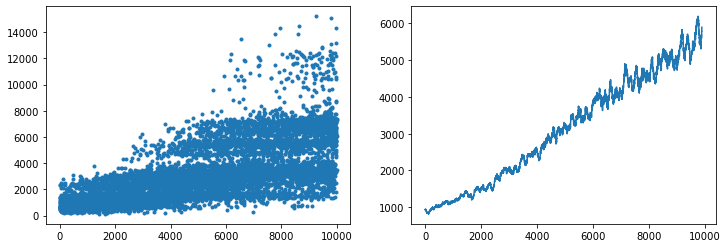

In [8]:
import matplotlib.pyplot as plt

N = 100
rolling_mean = [np.mean(scores[x:x+N]) for x in range(len(scores)-N+1)]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(range(len(scores)), scores, marker='.')
plt.subplot(1,2,2)
plt.plot(rolling_mean)
plt.show()

학습 데이터 보강

In [9]:
# 10.41 학습 데이터 보강
max_memory = 512*64

action_swap_array = [[0, 0, 2, 2, 1, 3, 1, 3],
                     [1, 3, 1, 3, 0, 0, 2, 2],
                     [2, 2, 0, 0, 3, 1, 3, 1],
                     [3, 1, 3, 1, 2, 2, 0, 0]]

def append_sample(state, action, reward, next_state, done):
    g0 = state
    g1 = g0[::-1,:,:]
    g2 = g0[:,::-1,:]
    g3 = g2[::-1,:,:]
    r0 = state.swapaxes(0,1)
    r1 = r0[::-1,:,:]
    r2 = r0[:,::-1,:]
    r3 = r2[::-1,:,:]

    g00 = next_state
    g10 = g00[::-1,:,:]
    g20 = g00[:,::-1,:]
    g30 = g20[::-1,:,:]
    r00 = next_state.swapaxes(0,1)
    r10 = r00[::-1,:,:]
    r20 = r00[:,::-1,:]
    r30 = r20[::-1,:,:]

    states = [g0, g1, g2, g3, r0, r1, r2, r3]
    next_states = [g00, g10, g20, g30, r00, r10, r20, r30]

    for i in range(8):
        memory.append([
            states[i],
            action_swap_array[action][i],
            reward,
            next_states[i],
            done
        ])

보강된 데이터로 재학습

In [ ]:
import math

def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits))
    sum_exp_logits = np.sum(exp_logits)
    return exp_logits / sum_exp_logits

max_episodes = 10001
epsilon = 0.9
epsilon_min = 0.1

scores = []
steps = []
iteration = 0

train_count = 0


for i in tqdm(range(max_episodes)):
    if i % 100 == 0 and i != 0:
        print('episode :', i, 'score mean:', np.mean(scores[-100:]), 'step mean:', np.mean(steps[-100:]), 'iteration:', iteration, 'epsilon:', epsilon)

    prev_obs = env.reset()

    score = 0
    step = 0
    not_move_list = np.array([1,1,1,1])
    prev_max = np.max(prev_obs)

    while True:
        iteration += 1

        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            x = preprocess(prev_obs)
            logits = model.predict(np.expand_dims(x, axis=0))[0]
            prob = softmax(logits)
            prob = prob * not_move_list
            action = np.argmax(prob)

        obs, reward, done, info = env.step(action)

        score += reward
        step += 1

        # not moved situation
        if reward == 0 and np.array_equal(obs, prev_obs):
            not_move_list[action] = 0
            continue
        else:
            not_move_list = np.array([1,1,1,1])

        # custom reward
        now_max = np.max(obs)
        if prev_max < now_max:
            prev_max = now_max
            reward = math.log(now_max, 2) * 0.1
        else:
            reward = 0

        reward += np.count_nonzero(prev_obs) - np.count_nonzero(obs) + 1

        append_sample(preprocess(prev_obs), action, reward, preprocess(obs), done)

        if len(memory) >= max_memory:
            train_model()
            memory = []

            train_count += 1
            if train_count % 4 == 0:
                target_model.set_weights(model.get_weights())

        prev_obs = obs

        if epsilon > 0.01 and iteration % 2500 == 0:
            epsilon = epsilon / 1.005

        if done:
            break

    scores.append(score)
    steps.append(step)

  0%|          | 0/10001 [00:00<?, ?it/s]

episode : 100 score mean: 1189.36 step mean: 129.95 iteration: 12995 epsilon: 0.8778336015235555
episode : 200 score mean: 1154.72 step mean: 126.83 iteration: 25678 epsilon: 0.860494212359595
episode : 300 score mean: 1214.52 step mean: 131.43 iteration: 38821 epsilon: 0.8393008150286649
episode : 400 score mean: 1299.68 step mean: 136.82 iteration: 52503 epsilon: 0.8145566138399872
episode : 500 score mean: 1394.04 step mean: 143.46 iteration: 66849 epsilon: 0.7944946288577645
episode : 600 score mean: 1410.2 step mean: 144.25 iteration: 81274 epsilon: 0.7710714001562543
episode : 700 score mean: 1441.96 step mean: 145.65 iteration: 95839 epsilon: 0.7483387332570208
episode : 800 score mean: 1529.0 step mean: 151.85 iteration: 111024 epsilon: 0.7262762690708524
episode : 900 score mean: 1562.56 step mean: 153.06 iteration: 126330 epsilon: 0.7048642487336177
episode : 1000 score mean: 1722.64 step mean: 167.81 iteration: 143111 epsilon: 0.6840834959104777
episode : 1100 score mean: 17

In [ ]:
import matplotlib.pyplot as plt

N = 100
rolling_mean = [np.mean(scores[x:x+N]) for x in range(len(scores)-N+1)]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(range(len(scores)), scores, marker='.')
plt.subplot(1,2,2)
plt.plot(rolling_mean)
plt.show()

테스트 1000회

In [ ]:
test_scores = []
max_tile = {}
iteration = 0
train_count = 0

for i in tqdm(range(1000)):
    if i % 100 == 0 and i != 0:
        print('episode :', i, 'score mean:', np.mean(scores[-100:]), 'step mean:', np.mean(steps[-100:]), 'iteration:', iteration, 'epsilon:', epsilon)

    prev_obs = env.reset()

    score = 0
    step = 0
    not_move_list = np.array([1,1,1,1])

    while True:
        iteration += 1

        x = preprocess(prev_obs)
        logits = model.predict(np.expand_dims(x, axis=0))[0]
        prob = softmax(logits)
        prob = prob * not_move_list
        action = np.argmax(prob)

        obs, reward, done, info = env.step(action)

        score += reward
        step += 1

        # not moved situation
        if reward == 0 and np.array_equal(obs, prev_obs):
            not_move_list[action] = 0
            continue
        else:
            not_move_list = np.array([1,1,1,1])

        prev_obs = obs

        if done:
            now_max = np.max(obs)
            max_tile[now_max] = max_tile.get(now_max, 0) + 1
            break

    test_scores.append(score)

print(max_tile)